In [1]:
import sys
sys.path.append('../xrun')

In [2]:
import re

from pathlib import Path

import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
import pulp
import seaborn as sns



sns.set(style="whitegrid")

from IPython.core.display import HTML

from scipy.sparse import linalg as sparse_linalg, issparse
from scipy.spatial.distance import cdist, euclidean

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin_min
from sklearn.utils import shuffle
from sklearn.utils.extmath import safe_sparse_dot

from xrun.data.run_info import RunInfo
from xrun.data.loader import load_dataset

In [3]:
# data_centers = np.random.randint(low=2, high=5)
raw_data, _ = make_blobs(n_samples=200, centers=10)

In [4]:
k = 10
n_points = raw_data.shape[0]

In [5]:
km = KMeans(n_clusters=k*2, n_init=10, max_iter=1)
km.fit(raw_data)
coreset_points = km.cluster_centers_

_, coreset_weights = np.unique(km.labels_, return_counts=True)

n_coreset_points = coreset_points.shape[0]

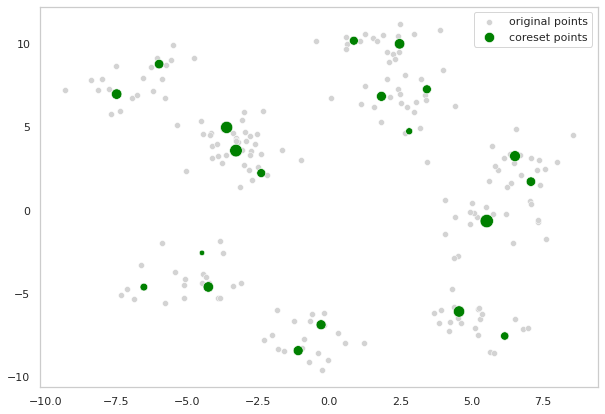

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x=raw_data[:,0], y=raw_data[:,1], color="lightgrey", label="original points", ax=ax)
sns.scatterplot(x=coreset_points[:,0], y=coreset_points[:,1], s=coreset_weights*10, color="green", label="coreset points", ax=ax)
ax.grid(False)

In [7]:
input_point_indices = np.arange(start=0, stop=n_points)
coreset_point_indices = np.arange(start=0, stop=n_coreset_points)
clustering_center_indices = np.arange(start=0, stop=k)

In [8]:
input_pairs = [(i, j) for i in input_point_indices for j in input_point_indices]
coreset_pairs = [(i, j) for i in coreset_point_indices for j in input_point_indices]

In [9]:
# X[i,j] \in [0,1] is a variable indicating whether point i is assigned to center j.
# X = np.zeros(shape=(n_points, k))
X = pulp.LpVariable.dicts(
    name="X",
    indices=input_pairs, 
    lowBound=0,
    upBound=1, 
)

In [10]:
# Y[i,j] \in [0,1] is a variable indicating whether coreset point i is assigned to center j.
# Y = np.zeros(shape=(n_coreset_points, k))
Y = pulp.LpVariable.dicts(
    name="Y",
    indices=coreset_pairs, 
    lowBound=0,
    upBound=1, 
)

In [11]:
#z[j] \in [0,1] is a variable indicating whether we have a center at point j.
# z = np.zeros(shape=(n_points, 1))
z = pulp.LpVariable.dicts(
    name="z",
    indices=[i for i in input_point_indices],
    lowBound=0,
    upBound=1, 
)

In [12]:
input_dist = pairwise_distances(raw_data)
coreset_dist = pairwise_distances(coreset_points, raw_data)

In [13]:
lp_problem = pulp.LpProblem("max-distortion-problem", pulp.LpMaximize)

# Set the objective
lp_problem += pulp.lpSum([input_dist[i,j] * X[(i, j)] for i, j in input_pairs]) - pulp.lpSum([coreset_dist[i,j] * coreset_weights[i] * Y[(i, j)] for i, j in coreset_pairs])

lp_problem += (pulp.lpSum([z[j] for j in range(n_points)]) == k, "constraint-exactly-k-centers")

for i in range(n_points):
    lp_problem += (pulp.lpSum([X[i,j] for j in range(n_points)]) == 1, f"constraint-input-point-{i}-has-cluster")

for i in range(n_points):
    for j in range(n_points):
        lp_problem += (X[i,j] <= z[j],
            f"constraint-input-point-{i}-has-cluster{j}"
        )


for i in range(n_coreset_points):
    lp_problem += (pulp.lpSum([Y[i,j] for j in range(n_points)]) == 1, f"constraint-coreset-point-{i}-has-cluster")

for i in range(n_coreset_points):
    for j in range(n_points):
        lp_problem += (Y[i,j] <= z[j],
            f"constraint-coreset-point-{i}-has-cluster-{j}"
        )

lp_problem.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/omar/.cache/pypoetry/virtualenvs/xrun-eubxByDy-py3.8/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/a4bc12264f304bcda527f0c65bf8c3cd-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/a4bc12264f304bcda527f0c65bf8c3cd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 44226 COLUMNS
At line 220227 RHS
At line 264449 BOUNDS
At line 308650 ENDATA
Problem MODEL has 44221 rows, 44200 columns and 132200 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 44221 (0) rows, 44200 (0) columns and 132200 (0) elements
0  Obj -0 Primal inf 229.99998 (221) Dual inf 378639.62 (39800)
446  Obj 145024.65 Primal inf 21083.999 (5929)
892  Obj 3448.6042 Primal inf 1570 (454)
1338  Obj 3335.2863 Primal inf 450.99998 (227)
1598  Obj 3308.6895
Optimal - objective value 3308.6895
Optimal obje

1

In [14]:
clustering_solution_indices = [i for i in range(n_points) if z[i].value()]


In [15]:
clustering_solution_centers = raw_data[clustering_solution_indices]

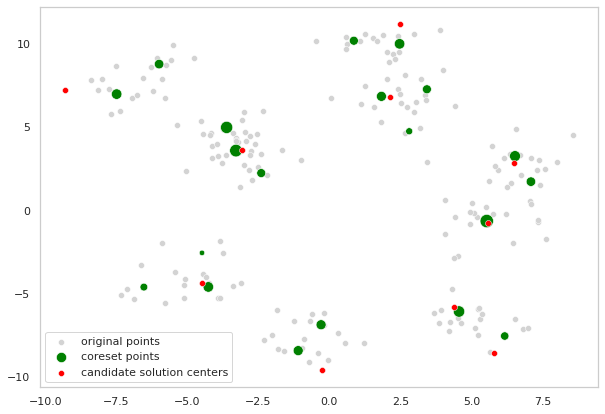

In [16]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x=raw_data[:,0], y=raw_data[:,1], color="lightgrey", label="original points", ax=ax)
sns.scatterplot(x=coreset_points[:,0], y=coreset_points[:,1], s=coreset_weights*10, color="green", label="coreset points", ax=ax)
sns.scatterplot(x=clustering_solution_centers[:,0], y=clustering_solution_centers[:,1], color="red", label="candidate solution centers", ax=ax)
ax.grid(False)